In [48]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Load dataset
dataset = pd.read_csv("Dataset.csv")

# Convert 'Time' to datetime format
dataset['Time'] = pd.to_datetime(dataset['Time'], format='%d/%b/%Y:%H:%M:%S %z')

# Feature Engineering
# 1. Frekuensi Akses Per IP
dataset['Request_Per_Minute'] = dataset.groupby('IP')['Time'].transform(
    lambda x: x.diff().dt.total_seconds().fillna(60).rsub(60).clip(lower=0).gt(0).cumsum()
)

# 2. Pola Waktu Akses
dataset['Time_Difference'] = dataset.groupby('IP')['Time'].diff().dt.total_seconds().fillna(0)

# Deteksi Pola Serangan
# 1. SQL Injection
sql_pattern = re.compile(r'.*(SELECT|UNION|INSERT|DELETE|DROP).*', re.IGNORECASE)
dataset['SQL_Injection'] = dataset['URL'].apply(lambda x: bool(sql_pattern.search(x)))

# 2. XSS Detection
xss_pattern = re.compile(r'.*(<script>|%3Cscript%3E).*', re.IGNORECASE)
dataset['XSS'] = dataset['URL'].apply(lambda x: bool(xss_pattern.search(x)))

# 3. Directory Traversal
dir_traversal_pattern = re.compile(r'.*\.\./.*')
dataset['Directory_Traversal'] = dataset['URL'].apply(lambda x: bool(dir_traversal_pattern.search(x)))

# 4. DoS Detection
# Rule: Requests from the same IP within 0.5 seconds
dataset['DoS'] = dataset.groupby('IP')['Time_Difference'].transform(lambda x: (x <= 0.5))

# Pastikan kolom Status diubah menjadi string
dataset['Status'] = dataset['Status'].astype(str)

# Brute Force Detection
# Rule: More than X failed attempts from the same IP
failed_attempts = dataset['Status'].apply(lambda x: x.startswith('4'))
dataset['Brute_Force'] = dataset.groupby('IP')['Status'].transform(
    lambda x: x.str.startswith('4').astype(int).rolling(window=10, min_periods=1).sum().gt(5)
)


# Normalisasi Data
numerical_features = ['Request_Per_Minute', 'Time_Difference']
dataset[numerical_features] = (dataset[numerical_features] - dataset[numerical_features].mean()) / dataset[numerical_features].std()

# Save the processed dataset
dataset.to_csv("processed_dataset.csv", index=False)

print("Processing complete. Processed dataset saved as 'processed_dataset.csv'.")


Processing complete. Processed dataset saved as 'processed_dataset.csv'.


In [49]:
import pandas as pd

# Baca file CSV
file_path = 'processed_dataset.csv'  
data = pd.read_csv(file_path)

# Tampilkan beberapa baris pertama untuk memastikan data terbaca dengan benar
print(data.head())


              IP User                       Time Method  \
0   66.249.79.63    -  2022-12-16 17:04:10+07:00    GET   
1  10.220.34.198    -  2022-12-16 17:04:12+07:00    GET   
2  10.220.34.198    -  2022-12-16 17:05:16+07:00    GET   
3  114.5.105.122    -  2022-12-16 17:06:07+07:00    GET   
4  114.5.105.122    -  2022-12-16 17:06:08+07:00    GET   

                                                 URL  Status    Size  \
0                                        /robots.txt     404     146   
1                                                  /     200     138   
2                                                  /     200  665508   
3                                                  /     200  665508   
4  /wp-content/plugins/elementor/assets/lib/eicon...     200   92444   

                       Referer  \
0                            -   
1                            -   
2                            -   
3                            -   
4  https://ittelkom-sby.ac.id/   

       

In [50]:
# Deteksi SQL Injection
import re

sql_pattern = re.compile(r".*(UNION|SELECT|INSERT|DELETE|UPDATE).*", re.IGNORECASE)
data['Detected_SQL_Injection'] = data['URL'].apply(lambda x: bool(sql_pattern.match(x)))

# Deteksi XSS
xss_pattern = re.compile(r".*(<script>|%3Cscript%3E).*", re.IGNORECASE)
data['Detected_XSS'] = data['URL'].apply(lambda x: bool(xss_pattern.match(x)))

# Deteksi Directory Traversal
dir_traversal_pattern = re.compile(r".*(\.\./|\.\.\\).*", re.IGNORECASE)
data['Detected_Directory_Traversal'] = data['URL'].apply(lambda x: bool(dir_traversal_pattern.match(x)))

# Gabungkan hasil ke dalam dataset
data['Any_Attack_Detected'] = data[['Detected_SQL_Injection', 'Detected_XSS', 'Detected_Directory_Traversal', 'DoS', 'Brute_Force']].any(axis=1)

# Tampilkan hasil deteksi
print(data[['IP', 'URL', 'Detected_SQL_Injection', 'Detected_XSS', 'Detected_Directory_Traversal', 'DoS', 'Brute_Force', 'Any_Attack_Detected']])


                    IP                                                URL  \
0         66.249.79.63                                        /robots.txt   
1        10.220.34.198                                                  /   
2        10.220.34.198                                                  /   
3        114.5.105.122                                                  /   
4        114.5.105.122  /wp-content/plugins/elementor/assets/lib/eicon...   
...                ...                                                ...   
199995  182.253.45.146                                                  /   
199996  182.253.45.146                                                  /   
199997  110.137.75.115  /wp-content/plugins/elementor/assets/lib/font-...   
199998  110.137.75.115  /wp-content/plugins/elementor/assets/lib/font-...   
199999  110.137.75.115  /wp-content/plugins/elementor/assets/lib/eicon...   

        Detected_SQL_Injection  Detected_XSS  Detected_Directory_Traversal 

In [51]:
from sklearn.model_selection import train_test_split

# Pisahkan fitur (X) dan label (y)
X = data[['Request_Per_Minute', 'Time_Difference']]  # Ganti dengan fitur yang relevan
y = data['Any_Attack_Detected']  # Target label

# Bagi data menjadi training (70%) dan testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan ukuran dataset
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (160000, 2), Testing set: (40000, 2)


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from time import perf_counter

# Latih model Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
start_train_time = perf_counter()
rf.fit(X_train, y_train)
train_time = perf_counter() - start_train_time

# Ulangi pengujian untuk waktu yang lebih akurat
num_repeats = 100
start_test_time = perf_counter()
for _ in range(num_repeats):
    y_pred_rf = rf.predict(X_test)
test_time = (perf_counter() - start_test_time) / num_repeats

# Evaluasi
accuracy = accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print(f"Random Forest:")
print(f"Train time (s): {train_time:.6f}")
print(f"Test time per prediction (s): {test_time:.6f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")


Random Forest:
Train time (s): 19.914352
Test time per prediction (s): 0.820781
Accuracy: 0.82
Recall: 0.81
Precision: 0.82
F1 Score: 0.81


In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time

# Latih model Decision Tree dan catat waktu pelatihan
start_train_time = time.time()
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Prediksi dan catat waktu pengujian
start_test_time = time.time()
y_pred_tree = tree.predict(X_test)
test_time = time.time() - start_test_time

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)

# Tampilkan hasil
print(f"Decision Tree:")
print(f"Train time (s): {train_time:.2f}")
print(f"Test time (s): {test_time:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")


Decision Tree:
Train time (s): 0.20
Test time (s): 0.01
Accuracy: 0.86
Recall: 0.78
Precision: 0.91
F1 Score: 0.84


In [54]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time

# Latih model XGBoost dan catat waktu pelatihan
start_train_time = time.time()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Tambahkan parameter untuk menghindari peringatan
xgb.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Prediksi dan catat waktu pengujian
start_test_time = time.time()
y_pred_xgb = xgb.predict(X_test)
test_time = time.time() - start_test_time

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

# Tampilkan hasil
print(f"XBboost:")
print(f"Train time (s): {train_time:.2f}")
print(f"Test time (s): {test_time:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")


c:\Users\asus\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XBboost:
Train time (s): 0.81
Test time (s): 0.04
Accuracy: 0.86
Recall: 0.81
Precision: 0.89
F1 Score: 0.85


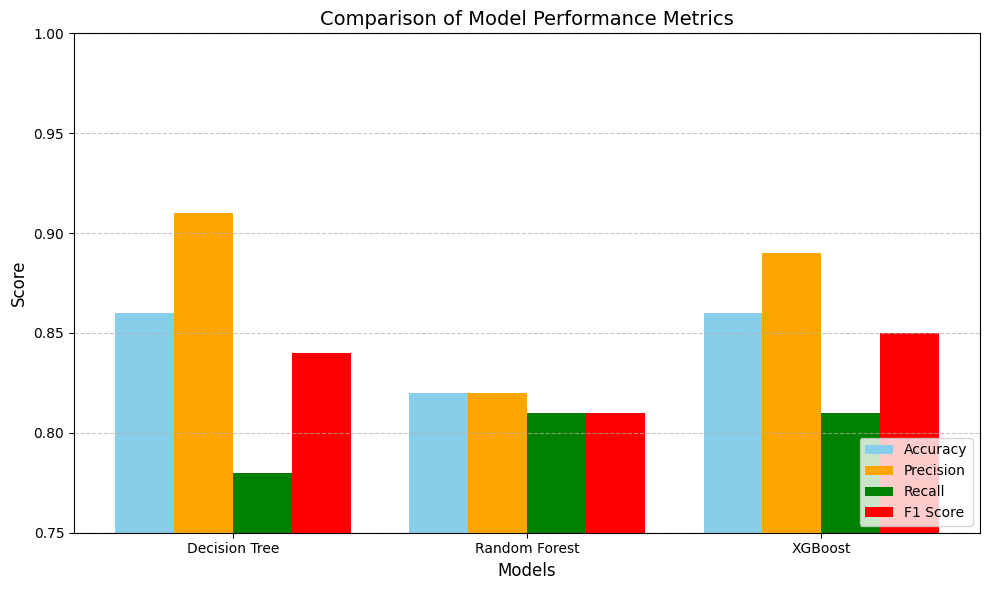

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Decision Tree', 'Random Forest', 'XGBoost']
accuracy = [0.86, 0.82, 0.86]
precision = [0.91, 0.82, 0.89]
recall = [0.78, 0.81, 0.81]
f1_score = [0.84, 0.81, 0.85]

# Bar width
bar_width = 0.2
x = np.arange(len(models))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width * 1.5, accuracy, width=bar_width, label='Accuracy', color='skyblue')
plt.bar(x - bar_width / 2, precision, width=bar_width, label='Precision', color='orange')
plt.bar(x + bar_width / 2, recall, width=bar_width, label='Recall', color='green')
plt.bar(x + bar_width * 1.5, f1_score, width=bar_width, label='F1 Score', color='red')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparison of Model Performance Metrics', fontsize=14)
plt.xticks(x, models, fontsize=10)
plt.ylim(0.75, 1.0)
plt.legend(loc='lower right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


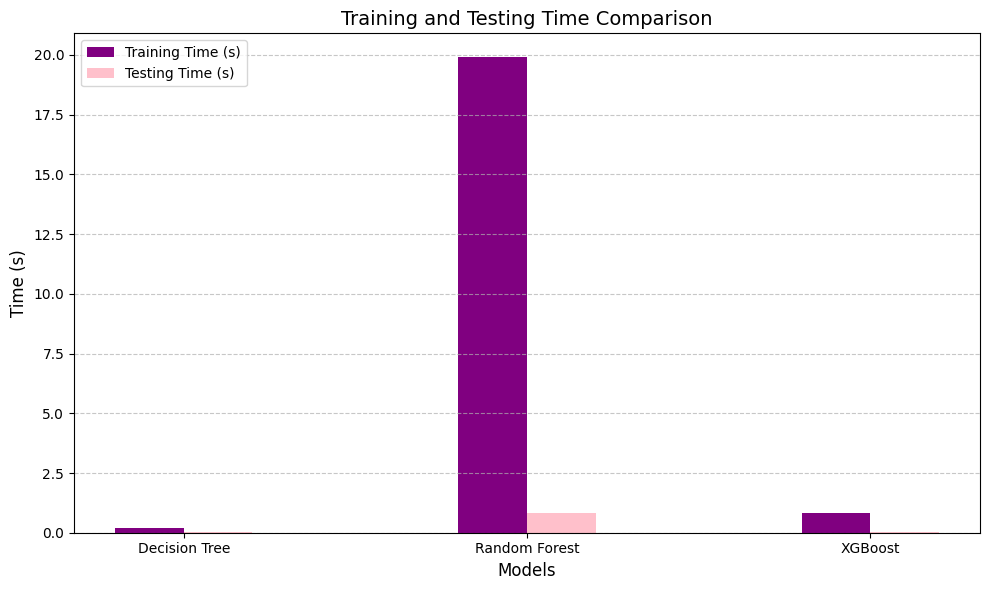

In [57]:
# Data for time comparison
train_time = [0.20, 19.91, 0.81]
test_time = [0.01, 0.82, 0.04]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width / 2, train_time, width=bar_width, label='Training Time (s)', color='purple')
plt.bar(x + bar_width / 2, test_time, width=bar_width, label='Testing Time (s)', color='pink')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Training and Testing Time Comparison', fontsize=14)
plt.xticks(x, models, fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
